Work plan
...


...


1. Importing the library and loading the model

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from matplotlib import animation
import roboticstoolbox as rtb
from spatialmath import SE3
from roboticstoolbox import DHRobot, RevoluteDH, jtraj

In [129]:
mm = 0.01
def UR3():
    L = [
        RevoluteDH(d=151.9*mm, a=0, alpha=pi/2, m=3.8, r=[0, 0, 0.1363], I=[0.010267, 0.010267, 0.00666, 0, 0, 0], Jm=0.0004, B=0.0015, Tc=[0.395, -0.435], G=-62.6111, qlim=[-2*pi, 2*pi]),
        RevoluteDH(d=0, a=-243.65*mm, alpha=0, m=8.393, r=[0.2125, 0, 0], I=[0.22689, 0.22689, 0.0151074, 0, 0, 0], Jm=0.0004, B=0.000817, Tc=[0.126, -0.071], G=107.815, qlim=[-2*pi, 2*pi]),
        RevoluteDH(d=0, a=-213.25*mm, alpha=0, m=2.275, r=[0.15, 0, 0], I=[0.0494433, 0.0494433, 0.004095, 0, 0, 0], Jm=0.0004, B=0.00138, Tc=[0.132, -0.105], G=-53.7063, qlim=[-2*pi, 2*pi]),
        RevoluteDH(d=112.35*mm, a=0, alpha=pi/2, m=1.219, r=[0, 0.018, 0], I=[0.111172, 0.111172, 0.21942, 0, 0, 0], Jm=0.000033, B=0.0000712, Tc=[0.0112, -0.0169], G=76.0364, qlim=[-2*pi, 2*pi]),
        RevoluteDH(d=85.35*mm, a=0, alpha=-pi/2, m=1.219, r=[0, 0, 0.032], I=[0.111172, 0.111172, 0.21942, 0, 0, 0], Jm=0.000033, B=0.0000826, Tc=[0.00926, -0.0145], G=71.923, qlim=[-2*pi, 2*pi]),
        RevoluteDH(d=81.9*mm, a=0, alpha=0, m=0.1879, r=[0, 0, 0.032], I=[0.017136, 0.017136, 0.033822, 0, 0, 0], Jm=0.000033, B=0.0000367, Tc=[0.00396, -0.0105], G=76.686, qlim=[-2*pi, 2*pi])
    ]
    return DHRobot(L, name='UR3')

In [130]:
robot = rtb.models.DH.UR3()
print(robot)

DHRobot: UR3 (by Universal Robotics), 6 joints (RRRRRR), dynamics, standard DH parameters
┌─────┬─────────┬─────────┬────────┐
│ θⱼ  │   dⱼ    │   aⱼ    │   ⍺ⱼ   │
├─────┼─────────┼─────────┼────────┤
│  q1 │  0.1519 │       0 │  90.0° │
│  q2 │       0 │ -0.2437 │   0.0° │
│  q3 │       0 │ -0.2132 │   0.0° │
│  q4 │  0.1124 │       0 │  90.0° │
│  q5 │ 0.08535 │       0 │ -90.0° │
│  q6 │  0.0819 │       0 │   0.0° │
└─────┴─────────┴─────────┴────────┘

┌──┬──┐
└──┴──┘

┌──────┬───────┬─────┬─────┬─────┬──────┬─────┐
│ name │ q0    │ q1  │ q2  │ q3  │ q4   │ q5  │
├──────┼───────┼─────┼─────┼─────┼──────┼─────┤
│   qr │  180° │  0° │  0° │  0° │  90° │  0° │
│   qz │  0°   │  0° │  0° │  0° │  0°  │  0° │
└──────┴───────┴─────┴─────┴─────┴──────┴─────┘



Variant 1

In [139]:
# 2. Параметры для генерации траектории
# Начальная точка: манипулятор "смотрит" вперёд и вверх
q_start = np.array([0, -np.pi/2, np.pi/2, 0, 0, 0])

# Конечная точка: манипулятор "смотрит" влево и вниз (суставы повернуты в другую сторону)
q_end = np.array([np.pi/2, -np.pi/3, np.pi/3, np.pi/4, np.pi/2, 0])
steps = 60

Variant 2

In [132]:
q_start = np.array([ np.pi,   -np.pi/2,  np.pi/2,  np.pi/2,  -np.pi/2, 0 ])
q_end   = np.array([-np.pi,    np.pi/2, -np.pi/2, -np.pi/2,   np.pi/2, 0 ])
steps = 15

3. Setting the trajectory

In [140]:
# 3. Класс для генерации траектории с искажениями
class TrajectoryGenerator:
    def __init__(self, q_start, q_end, steps):
        self.steps = steps
        t = np.linspace(0, 1, steps)
        self.q = np.zeros((steps, len(q_start)))
        for i in range(len(q_start)):
            A = q_end[i] - q_start[i]
            w = 2 * np.pi
            # Генерируем траекторию с искажениями
            self.q[:, i] = q_start[i] + A * (np.sin(w * t) + 0.2 * np.sin(5 * w * t) + 0.05 * np.random.randn(steps))
        self.qd = np.gradient(self.q, axis=0)
        self.qdd = np.gradient(self.qd, axis=0)

Found and fixed 0 invalid configurations
Total frames to animate: 60
Saving animation...
Animation saved successfully!


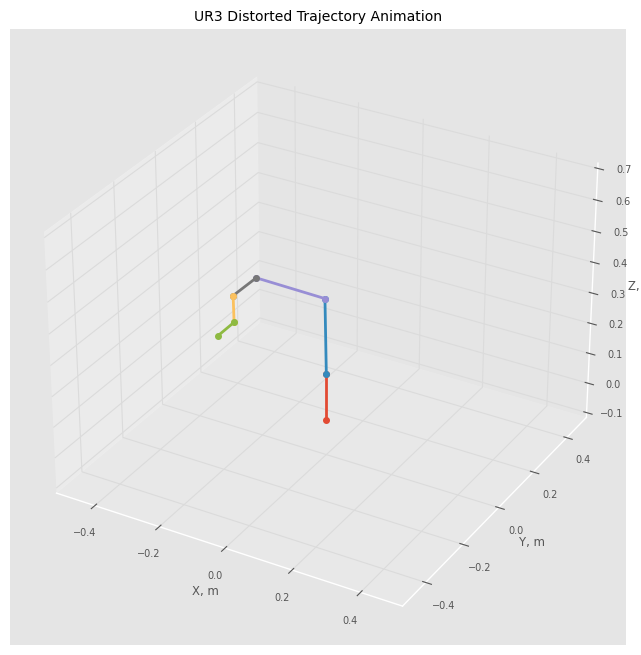

In [141]:
# Создаем траекторию с искажениями
traj_gen = TrajectoryGenerator(q_start, q_end, steps)
q_hist = traj_gen.q  # Используем сгенерированную траекторию

# 4. Проверка и исправление конфигураций
qlim = robot.qlim
invalid_frames = []

for i, q in enumerate(q_hist):
    if np.any(q < qlim[0]) or np.any(q > qlim[1]):
        print(f"Invalid configuration at frame {i}: {q}")
        invalid_frames.append(i)
        q_hist[i] = np.clip(q, qlim[0], qlim[1])

print(f"Found and fixed {len(invalid_frames)} invalid configurations")

# 5. Визуализация
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("UR3 Distorted Trajectory Animation")
ax.set_xlabel("X, m")
ax.set_ylabel("Y, m")
ax.set_zlabel("Z, m")
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])
ax.set_zlim([-0.1, 0.7])

# Создаем линии для 6 звеньев
lines = [ax.plot([], [], [], 'o-', lw=2, markersize=4)[0] for _ in range(6)]

# 6. Надежная функция FK
def get_xyz_points(q):
    """Вычисляем позиции всех сочленений с проверкой ошибок"""
    try:
        T = robot.fkine_all(q)
        return np.array([T[i].t for i in range(len(T))])
    except Exception as e:
        print(f"FK error at q={q}: {str(e)}")
        # Возвращаем безопасные точки при ошибке
        return np.array([
            [0, 0, 0],
            [0, 0, 0.1],
            [0, 0, 0.3],
            [0, 0, 0.6],
            [0, 0.2, 0.6],
            [0, 0.2, 0.8],
            [0.1, 0.2, 0.8]
        ])

# 7. Гарантированно возвращаем художников
def init():
    for line in lines:
        line.set_data([], [])
        line.set_3d_properties([])
    return tuple(lines)  # Возвращаем кортеж

def animate(i):
    q = q_hist[i]
    xyz = get_xyz_points(q)
    
    # Обновляем линии для каждого звена
    for j in range(6):
        if j < len(xyz) - 1:
            xs = [xyz[j][0], xyz[j+1][0]]
            ys = [xyz[j][1], xyz[j+1][1]]
            zs = [xyz[j][2], xyz[j+1][2]]
            lines[j].set_data(xs, ys)
            lines[j].set_3d_properties(zs)
    return tuple(lines)  # Всегда возвращаем кортеж художников

# 8. Проверка данных перед анимацией
if len(q_hist) == 0:
    raise ValueError("q_hist is empty! Run simulation first.")

print(f"Total frames to animate: {len(q_hist)}")

# 9. Создание анимации с контролем ошибок
try:
    ani = animation.FuncAnimation(
        fig, animate, frames=len(q_hist),
        init_func=init, blit=True, interval=50
    )
    
    # 10. Сохранение с обработкой ошибок
    print("Saving animation...")
    ani.save('ur3_distorted_trajectory.gif', writer='pillow', fps=20)
    print("Animation saved successfully!")
    
except Exception as e:
    print(f"Animation failed: {str(e)}")
    # Альтернативное сохранение: последний кадр
    animate(len(q_hist)-1)  # Рендерим последний кадр
    plt.savefig('ur3_last_frame.png')
    print("Saved last frame as fallback")

plt.show()

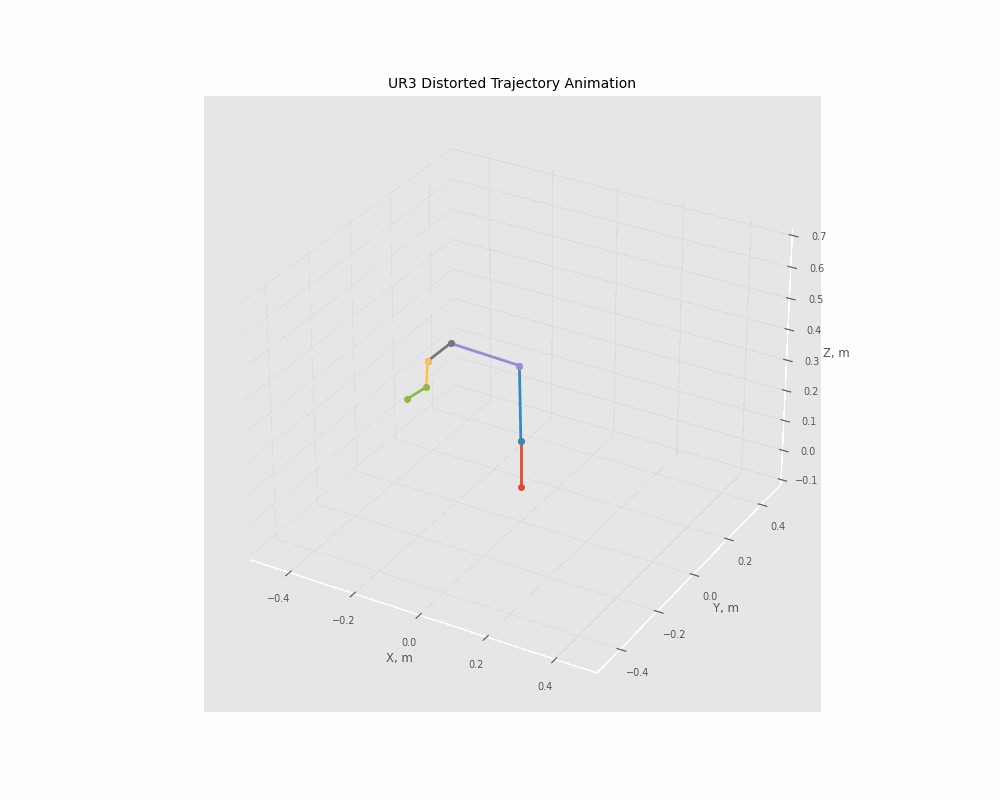

In [142]:
from IPython.display import Image
Image(filename='ur3_distorted_trajectory.gif', width=600) 

Found and fixed 0 invalid configurations


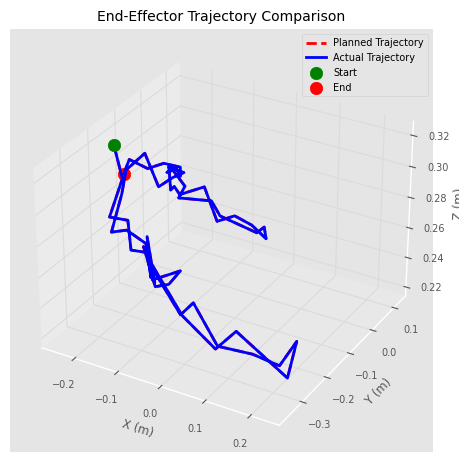

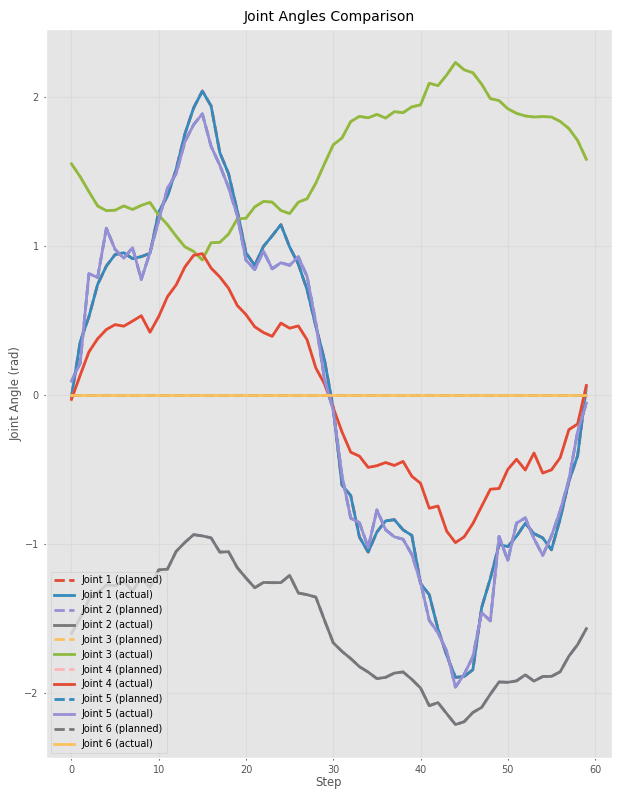

In [143]:
# 4. Генерация траектории
traj_gen = TrajectoryGenerator(q_start, q_end, steps)
q_plan = traj_gen.q.copy()  # Планируемая траектория (до коррекции)
q_hist = traj_gen.q.copy()  # Фактическая траектория (будет корректироваться)

# 5. Коррекция конфигураций
qlim = robot.qlim
invalid_frames = []

for i, q in enumerate(q_hist):
    if np.any(q < qlim[0]) or np.any(q > qlim[1]):
        invalid_frames.append(i)
        q_hist[i] = np.clip(q, qlim[0], qlim[1])

print(f"Found and fixed {len(invalid_frames)} invalid configurations")

# 6. Расчет координат для траекторий
def calculate_ee_positions(q_traj):
    positions = np.zeros((len(q_traj), 3))
    for i, q in enumerate(q_traj):
        T = robot.fkine(q)
        positions[i] = T.t
    return positions

xyz_plan = calculate_ee_positions(q_plan)  # Планируемые позиции
xyz_actual = calculate_ee_positions(q_hist)  # Фактические позиции

# 7. Визуализация сравнения траекторий
fig = plt.figure(figsize=(12, 10))

# 3D график траекторий
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(xyz_plan[:, 0], xyz_plan[:, 1], xyz_plan[:, 2], 'r--', label='Planned Trajectory', linewidth=2)
ax1.plot(xyz_actual[:, 0], xyz_actual[:, 1], xyz_actual[:, 2], 'b-', label='Actual Trajectory', linewidth=2)
ax1.scatter(xyz_plan[0, 0], xyz_plan[0, 1], xyz_plan[0, 2], c='g', s=80, label='Start')
ax1.scatter(xyz_plan[-1, 0], xyz_plan[-1, 1], xyz_plan[-1, 2], c='r', s=80, label='End')

ax1.set_title('End-Effector Trajectory Comparison')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.legend()
plt.show()

fig = plt.figure(figsize=(12, 8))
# График углов суставов
ax2 = fig.add_subplot(122)
for i in range(6):
    ax2.plot(q_plan[:, i], '--', label=f'Joint {i+1} (planned)', linewidth=2)
    ax2.plot(q_hist[:, i], '-', label=f'Joint {i+1} (actual)', linewidth=2)
ax2.set_title('Joint Angles Comparison')
ax2.set_xlabel('Step')
ax2.set_ylabel('Joint Angle (rad)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.savefig('trajectory_comparison.png')
plt.show()
